### Python Advanced. HW2. Pandas. <a name="Начало"></a>
---
# Riiid Answer Correctness Prediction
Track knowledge states of 1M+ students in the wild

### Оглавление: <a name="Оглавление"></a>

* [Задание](#Задание)
* [Решение](#Решение)
    * [Чтение данных, изменение типов](#Чтение_данных)
    * [Объединение таблиц](#Объединение_таблиц)
    * [Признаки](#Признаки)


---

### ЗАДАЧА <a name="Задание"></a>
Сбор и подготовка данных по прохождению студентами тестов на образовательной платформе.

Используя библиотеку pandas, необходимо проанализировать как можно больше характеристик, влияющих на успеваемость студентов.

### РЕСУРСЫ:
[Данные](https://www.kaggle.com/competitions/riiid-test-answer-prediction/data)  
[Яндекс.Диск](https://disk.yandex.ru/d/UUfhhnGWUt1jRQ)


### ОПИСАНИЕ ДАННЫХ
Для выполнения задания необходимы файлы **train.csv**, **lectures.csv**, **questions.csv**.

#### **TRAIN.CSV**
-   `row_id`: (int64) ID code for the row.
-   `timestamp`: (int64) the time in milliseconds between this user interaction and the first event completion from that user.
-   `user_id`: (int32) ID code for the user.
-   `content_id`: (int16) ID code for the user interaction
-   `content_type_id`: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
-   `task_container_id`: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.
-   `user_answer`: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
-   `answered_correctly`: (int8) if the user responded correctly. Read -1 as null, for lectures.
-   `prior_question_elapsed_time`: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
-   `prior_question_had_explanation`: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.


#### **QUESTIONS.CSV**: METADATA FOR THE QUESTIONS POSED TO USERS.
-   `question_id`: foreign key for the train/test content_id column, when the content type is question (0).
-   `bundle_id`: code for which questions are served together.
-   `correct_answer`: the answer to the question. Can be compared with the train user_answer column to check if the user was right.
-   `part`: the relevant section of the TOEIC test.
-   `tags`: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

#### **LECTURES.CSV**: METADATA FOR THE LECTURES WATCHED BY USERS AS THEY PROGRESS IN THEIR EDUCATION.
-   `lecture_id`: foreign key for the train/test content_id column, when the content type is lecture (1).
-   `part`: top level category code for the lecture.
-   `tag`: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
-   `type_of`: brief description of the core purpose of the lecture.

 - --

# РЕШЕНИЕ <a name="Решение"></a>

In [7]:
import pandas as pd

pd.set_option('display.min_rows', 30)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

## Чтение данных, изменение типов <a name="Чтение_данных"></a>

In [24]:
lectures_df = pd.read_csv('data/LECTURES.CSV',
                          dtype={'lecture_id': 'int16',
                                 'tag': 'int16',
                                 'part': 'int8',
                                 'type_of': 'category'
                                }
                         )
questions_df = pd.read_csv('data/QUESTIONS.CSV',
                          dtype={'question_id': 'int16',
                                 'bundle_id': 'int16',
                                 'correct_answer': 'int8',
                                 'part': 'int8',
                                }
                          )
train_df = pd.read_csv('data/TRAIN.CSV',
                       dtype={'row_id': 'int32',
                              'timestamp': 'int32',
                              'user_id': 'int32',
                              'content_id': 'int16',
                              'content_type_id': 'int8',
                              'task_container_id': 'int16',
                              'user_answer': 'int8',
                              'answered_correctly':'int8',
                              'prior_question_elapsed_time': 'float32',
                              'prior_question_had_explanation': 'boolean'
                             }, 
                       nrows=10_000_000,
                       index_col=0
                      )

In [25]:
lectures_df = lectures_df.rename(columns={"tag":"lect_tag",
                                          "part":"lect_part",
                                          "type_of":"lect_type_of"})

questions_df = questions_df.rename(columns={"bundle_id":"quest_bundle_id",
                                            "correct_answer":"quest_correct_answer",
                                            "part":"quest_part",
                                            "tags":"quest_tags",})

In [26]:
lectures_df.info()
print('_______________________________________________________________________')
questions_df.info()
print('_______________________________________________________________________')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   lecture_id    418 non-null    int16   
 1   lect_tag      418 non-null    int16   
 2   lect_part     418 non-null    int8    
 3   lect_type_of  418 non-null    category
dtypes: category(1), int16(2), int8(1)
memory usage: 2.8 KB
_______________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   question_id           13523 non-null  int16 
 1   quest_bundle_id       13523 non-null  int16 
 2   quest_correct_answer  13523 non-null  int8  
 3   quest_part            13523 non-null  int8  
 4   quest_tags            13522 non-null  object
dtypes: int16(2), int8(2), object(1)
memor

In [27]:
display(lectures_df.head(3))
display(questions_df.head(3))
display(train_df.head(5))

,lecture_id,lect_tag,lect_part,lect_type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept


,question_id,quest_bundle_id,quest_correct_answer,quest_part,quest_tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92


,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,<NA>
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False


## Объединение таблиц <a name="Объединение_таблиц"></a>

In [28]:
train_lectures_df = train_df.merge(lectures_df, how='left', left_on='content_id', right_on='lecture_id')
train_lectures_df.drop('lecture_id', axis=1, inplace=True)

full_df = train_lectures_df.merge(questions_df, how='left', left_on='content_id', right_on='question_id')
full_df.drop('question_id', axis=1, inplace=True)

# Освобождение памяти
train_df = train_df.iloc[0:0]
train_lectures_df = train_lectures_df.iloc[0:0]

In [29]:
display(lectures_df.head(3))
display(questions_df.head(3))
display(full_df.head(5))

,lecture_id,lect_tag,lect_part,lect_type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept


,question_id,quest_bundle_id,quest_correct_answer,quest_part,quest_tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92


,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lect_tag,lect_part,lect_type_of,quest_bundle_id,quest_correct_answer,quest_part,quest_tags
0,0,115,5692,0,1,3,1,NaN,<NA>,NaN,NaN,NaN,5692.0,3.0,5.0,151
1,56943,115,5716,0,2,2,1,37000.0,False,NaN,NaN,NaN,5716.0,2.0,5.0,168
2,118363,115,128,0,0,0,1,55000.0,False,NaN,NaN,NaN,128.0,0.0,1.0,131 149 92
3,131167,115,7860,0,3,0,1,19000.0,False,NaN,NaN,NaN,7860.0,0.0,1.0,131 104 81
4,137965,115,7922,0,4,1,1,11000.0,False,NaN,NaN,NaN,7922.0,1.0,1.0,131 149 92


## Признаки <a name="Признаки"></a>

In [30]:
# Проверка пустых ячеек
full_df.isnull().sum()

timestamp                               0
user_id                                 0
content_id                              0
content_type_id                         0
task_container_id                       0
user_answer                             0
answered_correctly                      0
prior_question_elapsed_time        234784
prior_question_had_explanation      39388
lect_tag                          9675185
lect_part                         9675185
lect_type_of                      9675185
quest_bundle_id                    118946
quest_correct_answer               118946
quest_part                         118946
quest_tags                         118946
dtype: int64

In [32]:
# Соотношение типов контента
full_df.content_type_id.value_counts(normalize=True)

0    0.98046
1    0.01954
Name: content_type_id, dtype: float64

Более 98% записей являются ответом на вопрос. Просмотр лекции - меннее 2%.

In [140]:
# Соотношения правильных ответов на вопрос
answ_corr_value_counts = full_df.answered_correctly.value_counts()
r_asw_pers = round(answ_corr_value_counts[1] / \
      (answ_corr_value_counts[1] + answ_corr_value_counts[0]) * 100,
      2)
print(f'Из всех ответов на вопрос: {r_asw_pers}% правильных и {100-r_asw_pers}% неправильных')

Из всех ответов на вопрос: 65.86% правильных и 34.14% неправильных


In [117]:
# Наиболее популярный правильный ответ
full_df_answ_corr = full_df[full_df.answered_correctly == 1]
full_df_answ_corr = full_df_answ_corr[['user_answer', 'answered_correctly']].groupby(['user_answer']).agg(['sum'])

In [163]:
print(round(full_df_answ_corr.iloc[0, 0]/full_df_answ_corr.iloc[2, 0], 2))
full_df_answ_corr

1.54


,answered_correctly
,sum
user_answer,
0,1835492.0
1,1727520.0
2,1191960.0
3,1702453.0


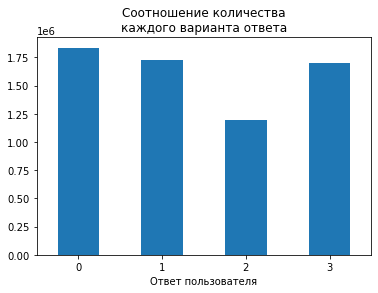

In [169]:
full_df_answ_corr.plot.bar(rot=0, title='''Соотношение количества
каждого варианта ответа''', legend=False, xlabel='Ответ пользователя', logy=False);

Наиболее частовстречаемый правильный ответ - 0. Наименее популярный ответ 2 встречается в 1.54 раз реже

In [180]:
questions_df_corr_answ = questions_df[['quest_correct_answer', 'question_id']].groupby(['quest_correct_answer']).agg(['count'])
questions_df_corr_answ

,question_id
,count
quest_correct_answer,
0,3716
1,3478
2,2785
3,3544


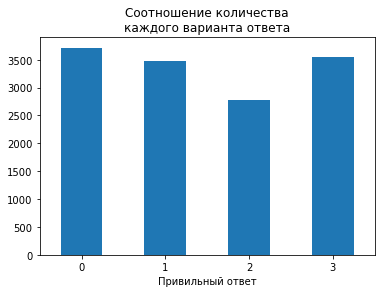

In [179]:
questions_df_corr_answ.plot.bar(rot=0, title='''Соотношение количества
каждого варианта ответа''', legend=False, xlabel='Привильный ответ');

Исходя из данного графика, в тесте без повторений вопросов самый частовстречаемым ответом будет являться ответ 0.

In [171]:
full_df.prior_question_had_explanation.value_counts()

True     8855555
False    1105057
Name: prior_question_had_explanation, dtype: Int64

### Создадим таблицу вопросов/ответов

In [186]:
full_df_quest = full_df[full_df.content_type_id == 0]
full_df_quest = full_df_quest[full_df_quest.answered_correctly != -1]

full_df_quest.drop(['content_type_id','lect_tag', 'lect_part', 'lect_type_of'], axis = 1, inplace = True)
full_df_quest.dropna(inplace = True)
full_df_quest.head(3)

,timestamp,user_id,content_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,quest_bundle_id,quest_correct_answer,quest_part,quest_tags
1,56943,115,5716,2,2,1,37000.0,False,5716.0,2.0,5.0,168
2,118363,115,128,0,0,1,55000.0,False,128.0,0.0,1.0,131 149 92
3,131167,115,7860,3,0,1,19000.0,False,7860.0,0.0,1.0,131 104 81


In [183]:
full_df_quest.answered_correctly.value_counts()

1    6430629
0    3334587
Name: answered_correctly, dtype: int64

In [187]:
# Проверим привильность заполнения таблиц в полях 'user_answer', 'correct_answer' и 'answered_correctly'
def check_answered_correctly(df):
    if df.loc['user_answer'] == df.loc['quest_correct_answer'] and df.loc['answered_correctly']:
        return True
    if df.loc['user_answer'] != df.loc['quest_correct_answer'] and not df.loc['answered_correctly']:
        return True
    else:
        return False

full_df_quest['Check_answered_correctly'] = full_df_quest.apply(check_answered_correctly, axis=1)
full_df_quest.head(3)

,timestamp,user_id,content_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,quest_bundle_id,quest_correct_answer,quest_part,quest_tags,Check_answered_correctly
1,56943,115,5716,2,2,1,37000.0,False,5716.0,2.0,5.0,168,True
2,118363,115,128,0,0,1,55000.0,False,128.0,0.0,1.0,131 149 92,True
3,131167,115,7860,3,0,1,19000.0,False,7860.0,0.0,1.0,131 104 81,True


In [188]:
full_df_quest['Check_answered_correctly'].value_counts()

True    9765216
Name: Check_answered_correctly, dtype: int64

Отсутствие `False` говорит о том, что ошибок нет. Можно удалить проверочный столбец

In [189]:
full_df_quest.drop(['Check_answered_correctly'], axis = 1, inplace = True)

#### Статистика по каждому вопросу

In [196]:
statistics_quest_content_id = full_df_quest[['content_id', 'answered_correctly']].groupby(['content_id']).agg(['mean'])
statistics_quest_content_id.columns = ['answered_correctly_mean']
statistics_quest_content_id['quest_part'] = questions_df.quest_part

statistics_quest_content_id.sort_values(by=['answered_correctly_mean'], ascending = False)

,answered_correctly_mean,quest_part
content_id,,
13009,1.000000,3
5872,1.000000,5
12917,1.000000,1
12919,1.000000,1
674,1.000000,2
8099,1.000000,7
12923,1.000000,1
12662,1.000000,1
2774,1.000000,4


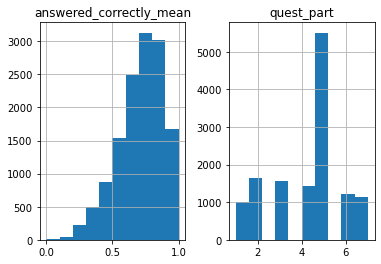

In [198]:
statistics_quest_content_id.hist(align='mid');

In [211]:
'''
Вопросы, на которые никто не ответил
'''
lst = list(statistics_quest_content_id[statistics_quest_content_id.answered_correctly_mean == 0].index)
print(f'{len(lst)} вопроса: {lst}')

2 вопроса: [7848, 7849]


In [213]:
'''
Вопросы, на которые ответили все
'''
lst = list(statistics_quest_content_id[statistics_quest_content_id.answered_correctly_mean == 1].index)
print(f'{len(lst)} вопросов: {lst}')

280 вопросов: [238, 243, 440, 563, 616, 674, 760, 850, 1323, 1385, 1634, 1893, 1906, 1907, 2229, 2476, 2709, 2774, 2775, 2812, 2842, 2844, 2902, 2927, 3032, 3039, 3043, 3102, 3103, 3104, 3198, 3200, 3449, 3534, 3555, 3578, 4275, 4389, 4618, 4632, 4652, 4656, 4662, 4663, 4741, 4869, 5041, 5079, 5377, 5475, 5537, 5538, 5770, 5774, 5816, 5826, 5872, 6223, 6236, 7137, 7138, 7139, 7195, 7199, 7361, 7364, 7372, 7373, 7375, 7566, 7567, 7568, 7850, 8050, 8052, 8053, 8094, 8095, 8097, 8098, 8099, 8101, 8103, 8104, 8105, 8108, 8109, 8110, 8112, 8114, 8117, 8129, 8130, 8131, 8132, 8480, 9265, 9268, 9304, 9726, 11560, 11563, 11631, 11695, 11724, 11902, 12283, 12284, 12285, 12303, 12315, 12330, 12331, 12340, 12348, 12351, 12371, 12389, 12393, 12435, 12439, 12471, 12504, 12515, 12519, 12540, 12543, 12546, 12548, 12565, 12570, 12587, 12590, 12601, 12612, 12615, 12616, 12617, 12620, 12623, 12625, 12628, 12637, 12641, 12642, 12644, 12649, 12651, 12653, 12654, 12656, 12657, 12662, 12715, 12726, 12728, 1

#### Статистика по каждому пользователю

In [214]:
statistics_quest_user_id = full_df_quest[['user_id', 'answered_correctly']].groupby(['user_id']).agg(['mean', 'sum', 'count'])
statistics_quest_user_id.columns = ['answered_correctly_mean', 'sum_correct', 'count']
statistics_quest_user_id.sort_values(by=['sum_correct'], ascending = False)

,answered_correctly_mean,sum_correct,count
user_id,,,
73289878,0.758820,11808.0,15561
111739511,0.836659,11658.0,13934
39919444,0.748755,11122.0,14854
119647028,0.857120,10840.0,12647
195124785,0.766406,10768.0,14050
42525121,0.788664,10505.0,13320
197212993,0.788396,10436.0,13237
93482981,0.829063,10224.0,12332
40224694,0.701735,9745.0,13887


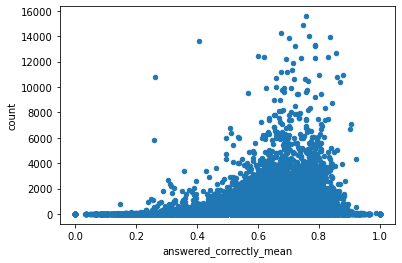

In [218]:
statistics_quest_user_id.plot.scatter(x='answered_correctly_mean', y='count');

Те пользователи, которые отвечали на все вопросы правильно или же, наоборот, на большинство вопросов неправильно, столнулись с небольшим количеством заданных им вопросов (до 2-х тысяч).

Те люди, которые ответили на наибольшее число вопросов, имеют "правильность" ответов в диапазоне от 0,6 до 0,9.

In [225]:
'''
Пользователи, которые ответили на все вопросы правильно
'''
df = statistics_quest_user_id[statistics_quest_user_id.answered_correctly_mean == 1]
lst = list(df.index)
print(f'{len(lst)} пользователей ответили на все вопросы')
df.sort_values(by='sum_correct', ascending=False)

25 пользователей ответили на все вопросы


,answered_correctly_mean,sum_correct,count
user_id,,,
48102728,1.0,40.0,40
173568036,1.0,39.0,39
45312560,1.0,29.0,29
98596877,1.0,29.0,29
159191533,1.0,29.0,29
147681450,1.0,29.0,29
192986922,1.0,22.0,22
147686041,1.0,20.0,20
177127512,1.0,18.0,18


In [240]:
print(f'Более половины студентов набрали коэффициент правильности ответов, равный \
{round(statistics_quest_user_id.answered_correctly_mean.quantile(0.75), 2)}')

Более половины студентов набрали коэффициент правильности ответов, равный 0.67


In [243]:
had_explanation_quest_user_id = full_df_quest[['user_id', 'prior_question_had_explanation']].groupby(['user_id']).agg(['sum']).sort_values(by=['user_id'])
had_explanation_quest_user_id.columns = ['explanation_sum']
had_explanation_quest_user_id.head(3)

,explanation_sum
user_id,
115,6
124,0
2746,11


In [245]:
statistics_quest_user_id = statistics_quest_user_id.merge(had_explanation_quest_user_id, how='left', left_on='user_id', right_on='user_id')

In [247]:
statistics_quest_user_id.head(3)

,answered_correctly_mean,sum_correct,count,explanation_sum
user_id,,,,
115,0.688889,31.0,45,6
124,0.206897,6.0,29,0
2746,0.611111,11.0,18,11


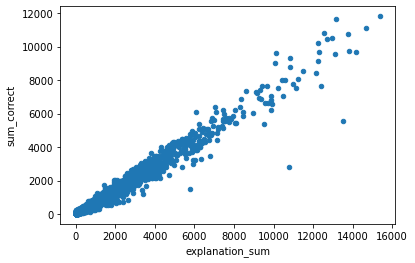

In [251]:
statistics_quest_user_id.plot(x='explanation_sum', y='sum_correct',  kind = 'scatter');

С увеличением числа "объяснений" наблюдается рост правильных ответов каждого студента

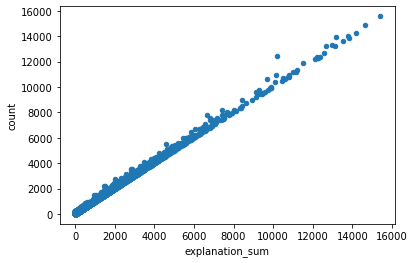

In [252]:
statistics_quest_user_id.plot(x='explanation_sum', y='count',  kind = 'scatter');

Чем больше пользователь отвечает на вопросы, тем больше смотрит "объяснения"

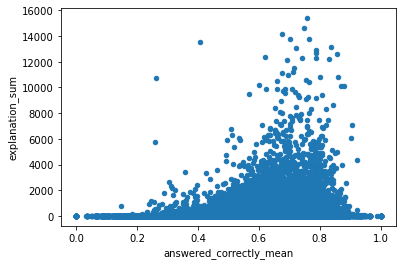

In [254]:
statistics_quest_user_id.plot(y='explanation_sum', x='answered_correctly_mean',  kind = 'scatter');

График повторяет зависимость `answered_correctly_mean` и `count`. То есть чем больше задано вопросов, тем больше просмотрено "объяснений" (см. график выше)

-- -

##### [ВЕРНУТЬСЯ К ОГЛАВЛЕНИЮ](#Оглавление)  <a name="Конец"> 